### Sparse Softmax Operator
This is an example of how to create and tune a sparse softmax operator.

In [1]:
import torch
import sparta
import matplotlib.pyplot as plt

device = 'cuda:0'

First, determine the input shape.

In [2]:
batch_size, features = 4096, 4096

Then generate a mask with block size $32\times32$, in which 90% of blocks are empty. 

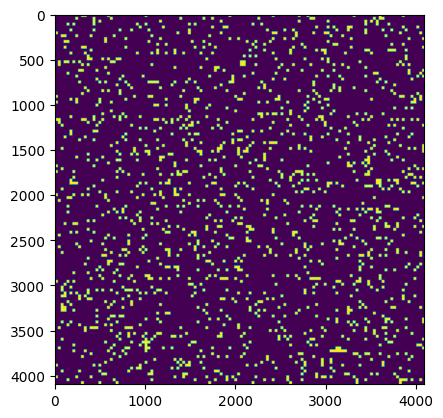

In [3]:
mask = sparta.testing.block_mask((batch_size, features), block=(32, 32), sparsity=0.9, device=device)
plt.imshow(mask.cpu().numpy())

Create a ```sparta.nn.SparseSoftmax``` operator using the mask.

Next, tune the sparse operator using a sample input. To save time, we will choose random search and take 30 trials here. This step may take a minute.

In [4]:
x = torch.rand((batch_size, features), device=device)
sparse_softmax = sparta.nn.SparseSoftmax(mask=mask)

# The tune() function will find the best config,
# build the sparse operator and return the best config.
best_config = sparta.nn.tune(
    sparse_softmax,
    sample_inputs=[x],
    algo='rand',
    max_trials=30,
)

print("before serialization", best_config)
import jsonpickle

with open("sparse_softmax_best_config.json", "w") as f:
    f.write(jsonpickle.dumps(best_config))
best_config = jsonpickle.loads(
    open("sparse_softmax_best_config.json", "r").read()
)
print("after serialization", best_config)

# If you have already tuned once and saved the best config,
# you can skip the tune() step and build the operator directly.
sparse_softmax.build(best_config['root'], sample_inputs=[x])

STAGE:2023-12-21 22:10:55 1613756:1613756 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:55 1613756:1613756 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:55 1613756:1613756 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:55 1613756:1613756 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:55 1613756:1613756 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:55 1613756:1613756 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:56 1613756:1613756 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:10:56 1613756:1613756 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:10:56 1613756:1613756 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:10:57 1613756:161375

before serialization {'root': {'forward:y': {'_impl': 'sparta', 'BLOCK_SIZE_H_VALUE': 16, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 1}}}
after serialization {'root': {'forward:y': {'_impl': 'sparta', 'BLOCK_SIZE_H_VALUE': 16, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 1}}}


Check whether the sparse operator works correctly.

We provide `sparta.testing.sparse_softmax_forward_reference()` function to calculate masked softmax using dense method.

In [5]:
torch.testing.assert_close(
    sparse_softmax(x),
    sparta.testing.sparse_softmax_forward_reference(x, mask),
)

The sparse softmax operator is ready to use. Let's compare it with the dense operator.

In [6]:
dense_softmax = torch.nn.Softmax(dim=-1)
dense_latency = sparta.testing.profile(dense_softmax, inputs=[x], num_warmups=100, num_iters=100)
print(f'Dense softmax forward latency: {dense_latency} ms')
sparse_latency = sparta.testing.profile(sparse_softmax, inputs=[x], num_warmups=100, num_iters=100)
print(f'Sparse softmax forward latency: {sparse_latency} ms')

Dense softmax forward latency: 0.1894105529785156 ms
Sparse softmax forward latency: 0.11769727706909179 ms
